In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from SSMs import SSM
from os.path import dirname, join as pjoin
import torch
print(torch.cuda.is_available())
from torch import nn
import time

dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

plt.close('all')
# Import Data
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_3.mat')#'dataset_sysID_3tanks.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_3.mat')
data_out = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'subsystems.mat')
data_sub = scipy.io.loadmat(filepath)

filepath = pjoin(folderpath, 'denormalize.mat')
data_max = scipy.io.loadmat(filepath)

# Extract data from dictionary
maxTrit, maxTdel = data_max['maxTrit'], data_max['maxTman']
Toutass_t, Toutass_v, Toutchill_t, Toutchill_v = data_sub['Toutass_train'], data_sub['Toutass_val'], data_sub['Toutchillers_train'], data_sub['Toutchillers_val']
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
nExp = yExp.size

t = time__

t_end = t.size

False
False


# Users
## inputs :    disturbances :     outputs :
yExp[:,1] (Tman)          Q_users               yExp[:,0] (Trit)

In [2]:
# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 2) 
y = torch.zeros(nExp, t_end, 1)

# Set input number
inputnumberD = 1

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
    (
        torch.from_numpy(buildtot[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1),  # Q_users
        torch.from_numpy(yExp[0, j][:, 1]).unsqueeze(1)    # Tman
    ),
    dim=-1
)
   
    y[j, :, :] = (torch.from_numpy(yExp[0, j][:,0]).unsqueeze(1) ) #Trit
    
seed = 55
torch.manual_seed(seed)

In [3]:
idd = 2
hdd = 150
odd = 1

RNN = (SSM
       (#N=3,
        in_features=idd,
        out_features=odd,
        #mid_features=21,
        state_features=hdd,
        scan = True,
        ))
if (torch.cuda.is_available()):
    RNN.cuda()

total_params = sum(p.numel() for p in RNN.parameters())
print(f"Number of parameters: {total_params}")

#RNN = torch.jit.script(RNN)

MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

t_end = yExp[0, 0].shape[0]

epochs = 300
LOSS = np.zeros(epochs)


Number of parameters: 1864


In [4]:

t0= time.time()
for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    yRNN = RNN(u)
    loss = MSE(yRNN, y)
    loss.backward()
    print(u.grad)
    optimizer.step()
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss

t1= time.time()

total_time= t1-t0

None
Epoch: 1 	||	 Loss: 0.08800608664751053
None
Epoch: 2 	||	 Loss: 0.06720063835382462
None
Epoch: 3 	||	 Loss: 0.028748204931616783
None
Epoch: 4 	||	 Loss: 0.005674601066857576
None
Epoch: 5 	||	 Loss: 0.04297191649675369
None
Epoch: 6 	||	 Loss: 0.05534732714295387
None
Epoch: 7 	||	 Loss: 0.015191209502518177
None
Epoch: 8 	||	 Loss: 0.007185997907072306
None
Epoch: 9 	||	 Loss: 0.023265520110726357
None
Epoch: 10 	||	 Loss: 0.03218798711895943
None
Epoch: 11 	||	 Loss: 0.03459065780043602
None
Epoch: 12 	||	 Loss: 0.03279156982898712
None
Epoch: 13 	||	 Loss: 0.02780359424650669
None
Epoch: 14 	||	 Loss: 0.02095162682235241
None
Epoch: 15 	||	 Loss: 0.01285191997885704
None
Epoch: 16 	||	 Loss: 0.005109834019094706
None
Epoch: 17 	||	 Loss: 0.000711020256858319
None
Epoch: 18 	||	 Loss: 0.002697636839002371
None
Epoch: 19 	||	 Loss: 0.008943113498389721
None
Epoch: 20 	||	 Loss: 0.011548439972102642
None
Epoch: 21 	||	 Loss: 0.008832193911075592
None
Epoch: 22 	||	 Loss: 0.0043

In [5]:
nExp = yExp_val.size
t_end = yExp_val[0,0].shape[0]
uval = torch.zeros(nExp, t_end, 2)
yval = torch.zeros(nExp, t_end, 1)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
    (
        torch.from_numpy(buildtot_val[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1),  # Q_users
        torch.from_numpy(yExp_val[0, j][:, 1]).unsqueeze(1)    # Tman
    ),
    dim=-1
)
   
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j][:,0]).unsqueeze(1) ) #Trit
 
yRNN_val = RNN(uval)
yRNN_val = torch.squeeze(yRNN_val)
yval = torch.squeeze(yval)

loss_val = MSE(yRNN_val, yval)

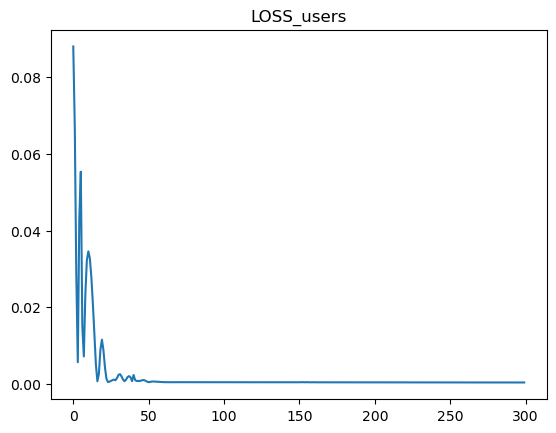

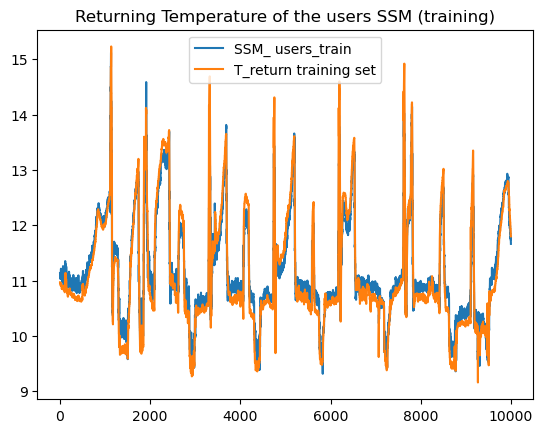

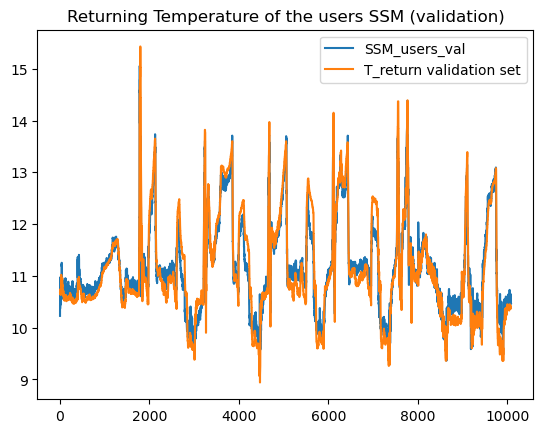

Loss Validation SSM users with 150 neurons : 0.00035353415296413004


In [6]:
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS_users")
plt.show()

plt.figure('9')
plt.plot(maxTrit.item()*yRNN[0, 10000:20000, 0].cpu().detach().numpy(), label='SSM_ users_train')
plt.plot(maxTrit.item()*y[0, 10000:20000, 0].cpu().detach().numpy(), label='T_return training set')
plt.title("Returning Temperature of the users SSM (training)")
plt.legend()
plt.show()

plt.figure('12')
plt.plot(maxTrit.item()*yRNN_val.cpu().detach().numpy(), label='SSM_users_val')
plt.plot(maxTrit.item()*yval.cpu().detach().numpy(), label='T_return validation set')
plt.title("Returning Temperature of the users SSM (validation)")
plt.legend()
plt.show()

print(f"Loss Validation SSM users with {hdd} neurons : {loss_val}")

# Absorber
## inputs :    disturbances :     outputs :
yExp[:,0] (Trit)          Q_abs, Text               Toutass

Number of parameters: 1864
None
Epoch: 1 	||	 Loss: 0.010006156750023365
None
Epoch: 2 	||	 Loss: 0.008860052563250065
None
Epoch: 3 	||	 Loss: 0.009145262651145458
None
Epoch: 4 	||	 Loss: 0.007355077657848597
None
Epoch: 5 	||	 Loss: 0.00767727242782712
None
Epoch: 6 	||	 Loss: 0.00601158756762743
None
Epoch: 7 	||	 Loss: 0.004283689893782139
None
Epoch: 8 	||	 Loss: 0.002991207642480731
None
Epoch: 9 	||	 Loss: 0.002666371874511242
None
Epoch: 10 	||	 Loss: 0.0027064939495176077
None
Epoch: 11 	||	 Loss: 0.0016341849695891142
None
Epoch: 12 	||	 Loss: 0.005565164610743523
None
Epoch: 13 	||	 Loss: 0.005463508423417807
None
Epoch: 14 	||	 Loss: 0.0029461027588695288
None
Epoch: 15 	||	 Loss: 0.0014819166390225291
None
Epoch: 16 	||	 Loss: 0.002495918655768037
None
Epoch: 17 	||	 Loss: 0.003085971111431718
None
Epoch: 18 	||	 Loss: 0.002815651474520564
None
Epoch: 19 	||	 Loss: 0.003783838590607047
None
Epoch: 20 	||	 Loss: 0.003141761524602771
None
Epoch: 21 	||	 Loss: 0.002615974517

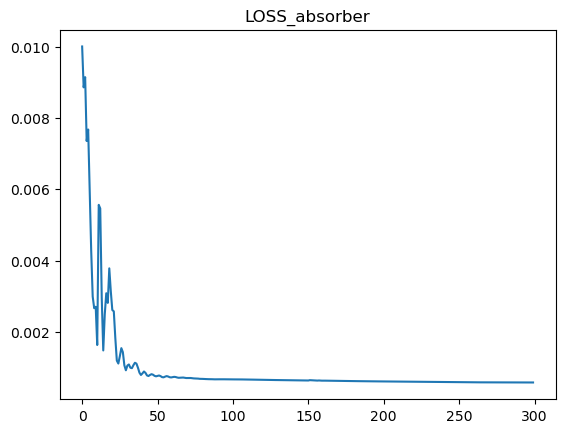

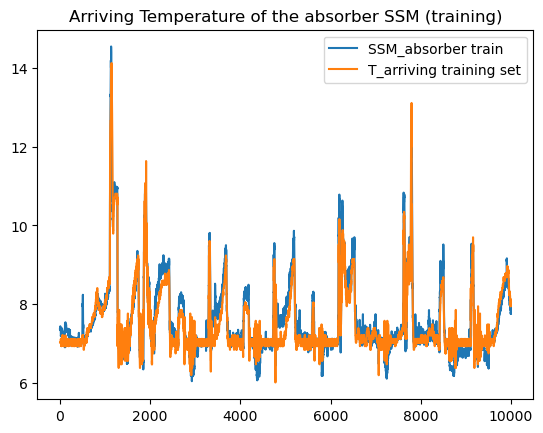

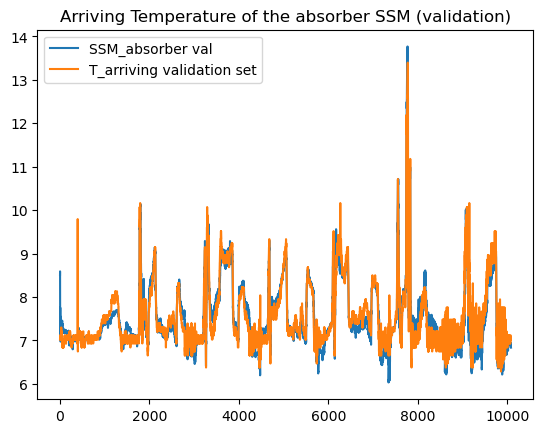

Loss Validation single RNN: 0.0004109021683689207


In [7]:
# Initialize input and output tensors
t_end = t.size
u = torch.zeros(nExp, t_end, 2) 
y = torch.zeros(nExp, t_end, 1)

# Set input number
inputnumberD = 1

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp[0,j][:,-1]).unsqueeze(1) ,  #Qabs
        #torch.from_numpy(dExp[0, j][:, 0]).unsqueeze(1) ,   # Text
        torch.from_numpy(yExp[0, j][:, 0]).unsqueeze(1)    # Trit
    ),
    dim=-1
)
    y[j, :, :] = torch.from_numpy(Toutass_t[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1) #Toutabs
    
seed = 55
torch.manual_seed(seed)


idd = 2
hdd = 150
odd = 1

RNN = (SSM
       (#N=3,
        in_features=idd,
        out_features=odd,
        #mid_features=21,
        state_features=hdd,
        scan = True,
        ))
if (torch.cuda.is_available()):
    RNN.cuda()

total_params = sum(p.numel() for p in RNN.parameters())
print(f"Number of parameters: {total_params}")

#RNN = torch.jit.script(RNN)

MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

t_end = yExp[0, 0].shape[0]

epochs = 300
LOSS = np.zeros(epochs)



t0= time.time()
for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    yRNN = RNN(u)
    loss = MSE(yRNN, y)
    loss.backward()
    print(u.grad)
    optimizer.step()
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss

t1= time.time()

total_time= t1-t0

nExp = yExp_val.size
t_end = yExp_val[0,0].shape[0]
uval = torch.zeros(nExp, t_end, 2)
yval = torch.zeros(nExp, t_end, 1)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp_val[0,j][:,-1]).unsqueeze(1),  #Qabs
        #torch.from_numpy(dExp_val[0, j][:, 0]).unsqueeze(1),   # Text
        torch.from_numpy(yExp_val[0, j][:, 0]).unsqueeze(1)   # Trit
    ),
    dim=-1
)
   
    yval[j, :, :] = torch.from_numpy(Toutass_v[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1) #Toutabs
 
yRNN_val = RNN(uval)
yRNN_val = torch.squeeze(yRNN_val)
yval = torch.squeeze(yval)

loss_val = MSE(yRNN_val, yval)

plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS_absorber")
plt.show()

plt.figure('9')
plt.plot(maxTdel.item()*yRNN[0, 10000:20000, 0].cpu().detach().numpy(), label='SSM_absorber train')
plt.plot(maxTdel.item()*y[0, 10000:20000, 0].cpu().detach().numpy(), label='T_arriving training set')
plt.title("Arriving Temperature of the absorber SSM (training)")
plt.legend()
plt.show()

plt.figure('12')
plt.plot(maxTdel.item()*yRNN_val.cpu().detach().numpy(), label='SSM_absorber val')
plt.plot(maxTdel.item()*yval.cpu().detach().numpy(), label='T_arriving validation set')
plt.title("Arriving Temperature of the absorber SSM (validation)")
plt.legend()
plt.show()

print(f"Loss Validation single RNN: {loss_val}")

# Chillers
## inputs :    disturbances :     outputs :
yExp[:,0] (Trit)          I/O               Toutchill

Number of parameters: 1864
None
Epoch: 1 	||	 Loss: 0.06771273165941238
None
Epoch: 2 	||	 Loss: 0.05086002126336098
None
Epoch: 3 	||	 Loss: 0.026076460257172585
None
Epoch: 4 	||	 Loss: 0.03547273948788643
None
Epoch: 5 	||	 Loss: 0.04613489657640457
None
Epoch: 6 	||	 Loss: 0.02012111060321331
None
Epoch: 7 	||	 Loss: 0.013407847844064236
None
Epoch: 8 	||	 Loss: 0.0191800519824028
None
Epoch: 9 	||	 Loss: 0.021588580682873726
None
Epoch: 10 	||	 Loss: 0.01990501768887043
None
Epoch: 11 	||	 Loss: 0.015039381571114063
None
Epoch: 12 	||	 Loss: 0.008302422240376472
None
Epoch: 13 	||	 Loss: 0.002189388731494546
None
Epoch: 14 	||	 Loss: 0.0027061302680522203
None
Epoch: 15 	||	 Loss: 0.006542906630784273
None
Epoch: 16 	||	 Loss: 0.005429359152913094
None
Epoch: 17 	||	 Loss: 0.003233487717807293
None
Epoch: 18 	||	 Loss: 0.002181780757382512
None
Epoch: 19 	||	 Loss: 0.0019018466118723154
None
Epoch: 20 	||	 Loss: 0.0016795748379081488
None
Epoch: 21 	||	 Loss: 0.0015625761589035392

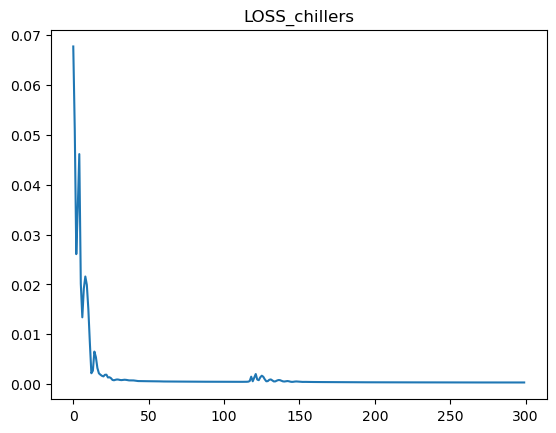

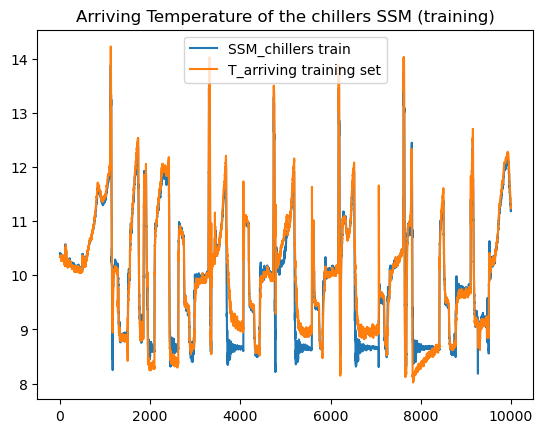

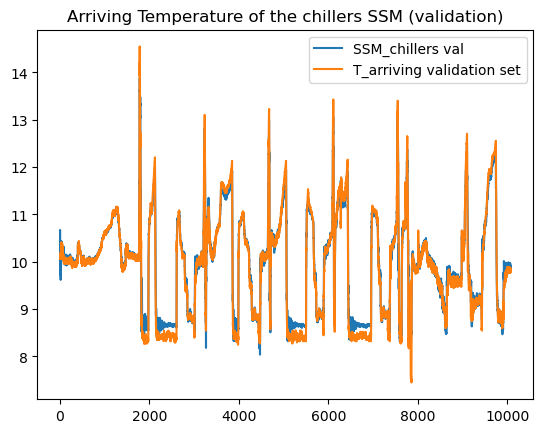

Loss Validation single RNN: 0.00015989119128789753


In [ ]:
# Initialize input and output tensors
t_end = t.size
u = torch.zeros(nExp, t_end, 2) 
y = torch.zeros(nExp, t_end, 1)

# Set input number
inputnumberD = 1

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp[0,j][:,-2]).unsqueeze(1) ,  #I/O
        #torch.from_numpy(dExp[0, j][:, 0]).unsqueeze(1) ,   # Text
        torch.from_numpy(yExp[0, j][:, 0]).unsqueeze(1)    # Trit
    ),
    dim=-1
)
   
    y[j, :, :] = (torch.from_numpy(Toutchill_t[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1)) #Toutchill
     
seed = 55
torch.manual_seed(seed)


idd = 2
hdd = 150
odd = 1

RNN = (SSM
       (#N=3,
        in_features=idd,
        out_features=odd,
        #mid_features=21,
        state_features=hdd,
        scan = True,
        ))
if (torch.cuda.is_available()):
    RNN.cuda()

total_params = sum(p.numel() for p in RNN.parameters())
print(f"Number of parameters: {total_params}")

MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

t_end = yExp[0, 0].shape[0]

epochs = 300
LOSS = np.zeros(epochs)



t0= time.time()
for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    yRNN = RNN(u)
    loss = MSE(yRNN, y)
    loss.backward()
    print(u.grad)
    optimizer.step()
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss

t1= time.time()

total_time= t1-t0

nExp = yExp_val.size
t_end = yExp_val[0,0].shape[0]
uval = torch.zeros(nExp, t_end, 2)
yval = torch.zeros(nExp, t_end, 1)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp_val[0,j][:,-2]).unsqueeze(1),  #I/O
        #torch.from_numpy(dExp_val[0, j][:, 0]).unsqueeze(),   # Text
        torch.from_numpy(yExp_val[0, j][:, 0]).unsqueeze(1)    # Trit
    ),
    dim=-1
)
   
    yval[j, :, :] = torch.from_numpy(Toutchill_v[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1) #Toutchill
   
 
yRNN_val = RNN(uval)
yRNN_val = torch.squeeze(yRNN_val)
yval = torch.squeeze(yval)

loss_val = MSE(yRNN_val, yval)

plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS_chillers")
plt.show()

plt.figure('9')
plt.plot(maxTdel.item()*yRNN[1, 10000:20000, 0].cpu().detach().numpy(), label='SSM_chillers train')
plt.plot(maxTdel.item()*y[1, 10000:20000, 0].cpu().detach().numpy(), label='T_arriving training set')
plt.title("Arriving Temperature of the chillers SSM (training)")
plt.legend()
plt.show()

plt.figure('12')
plt.plot(maxTdel.item()*yRNN_val.cpu().detach().numpy(), label='SSM_chillers val')
plt.plot(maxTdel.item()*yval.cpu().detach().numpy(), label='T_arriving validation set')
plt.title("Arriving Temperature of the chillers SSM (validation)")
plt.legend()
plt.show()

print(f"Loss Validation single RNN: {loss_val}")

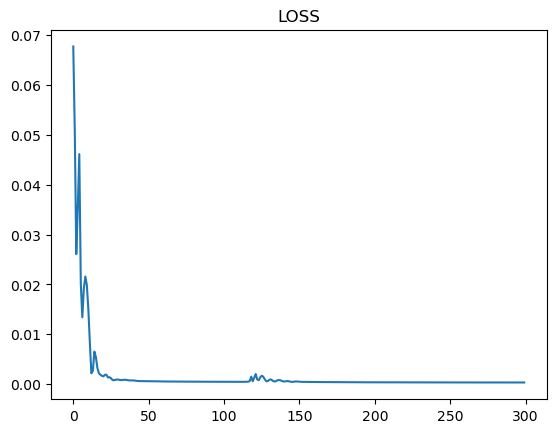

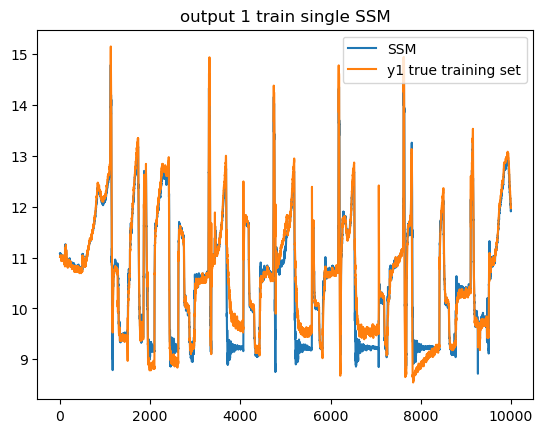

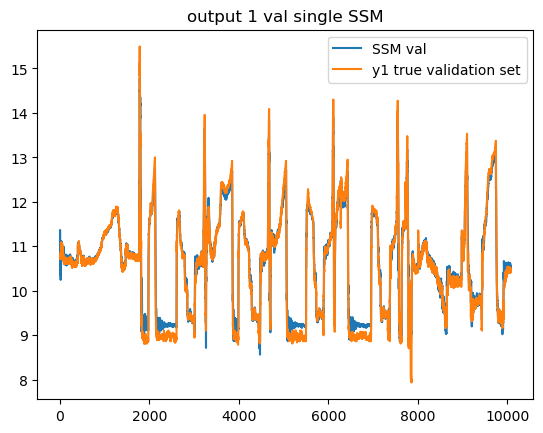

Loss Validation single RNN: 0.00015989119128789753


In [9]:
nExp = yExp_val.size
t_end = yExp_val[0,0].shape[0]
uval = torch.zeros(nExp, t_end, 2)
yval = torch.zeros(nExp, t_end, 1)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp_val[0,j][:,-2]).unsqueeze(1),  #I/O
        #torch.from_numpy(dExp_val[0, j][:, 0]).unsqueeze(),   # Text
        torch.from_numpy(yExp_val[0, j][:, 0]).unsqueeze(1)    # Trit
    ),
    dim=-1
)
   
    yval[j, :, :] = torch.from_numpy(Toutchill_v[j * t_end: (j + 1) * t_end, 0]).unsqueeze(1) #Toutchill
   
 
yRNN_val = RNN(uval)
yRNN_val = torch.squeeze(yRNN_val)
yval = torch.squeeze(yval)

loss_val = MSE(yRNN_val, yval)

plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

plt.figure('9')
plt.plot(maxTrit.item()*yRNN[0, 10000:20000, 0].cpu().detach().numpy(), label='SSM')
plt.plot(maxTrit.item()*y[0, 10000:20000, 0].cpu().detach().numpy(), label='y1 true training set')
plt.title("output 1 train single SSM")
plt.legend()
plt.show()

plt.figure('12')
plt.plot(maxTrit.item()*yRNN_val.cpu().detach().numpy(), label='SSM val')
plt.plot(maxTrit.item()*yval.cpu().detach().numpy(), label='y1 true validation set')
plt.title("output 1 val single SSM")
plt.legend()
plt.show()

print(f"Loss Validation single RNN: {loss_val}")